In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

Each csv file corresponds to one autotrack metric. Within each file, the rows correspond to patients and the columns correspond to bundles. We combine all of these dataframes into one dataframe with four columns: sub (patient), bundle, metric (which autotrack metric), score (autotrack score of this metric)

In [76]:
datapath = "../../hcpd_selection_and_completeness/"
path = datapath + 'outputs/metrics'
source_files = sorted(Path(path).glob('*.csv'))

dfs = []
for file in source_files:
    df = pd.read_csv(file)
    df = pd.melt(df, ["sub"],
                       var_name="bundle", value_name="score")
    df['metric'] = file.name[:-4]
    dfs.append(df)

In [77]:
metrics = pd.concat(dfs)

In [78]:
metrics.to_csv("../../outputs/metrics_df.csv")

In [79]:
pd.read_csv("../../outputs/metrics_df.csv")
metrics.head(0)

,sub,bundle,score,metric


### Add demographics 

In [80]:
dems = pd.read_csv(datapath + "data/hcpd_input_demos.csv", low_memory=False) # includes sex, age, site
tracts = pd.read_csv(datapath + "data/tract_list.csv")

In [81]:
dems["sub"] = ["sub-" + s_id[3:] for s_id in dems["src_subject_id"]]

In [82]:
def add_dems(dem, dems_df=dems, df=metrics):
    sid_to_dem = dict(zip(dems_df["sub"], dems_df[dem]))
    df[dem] = [sid_to_dem[sid] for sid in df["sub"]]

In [83]:
add_dems("site")
add_dems("sex")
add_dems("interview_age")
metrics.head()

,sub,bundle,score,metric,site,sex,interview_age
0,sub-0001305,ArcuateFasciculusL,1.05793,ad,WashU,M,143
1,sub-0021614,ArcuateFasciculusL,1.13199,ad,Harvard,F,110
2,sub-0022919,ArcuateFasciculusL,1.06170,ad,UCLA,F,117
3,sub-0026119,ArcuateFasciculusL,1.04271,ad,Harvard,F,182
4,sub-0029630,ArcuateFasciculusL,1.06039,ad,UCLA,F,221


In [84]:
# making categorical values into numerical values so that their correlation can be assessed
metrics["sex"].replace(["M", "F"], [0, 1], inplace = True)
metrics["site"].replace(["WashU", "UCLA", "Harvard", "UMinn"], [0, 1, 2, 3], inplace=True)

We make another dataframe with the same data, but restructured to have all metrics as columns, to allow for correlation analysis. 

In [85]:
# Make sure to add any demographics as indices in the following pivot command

In [86]:
metrics_long = metrics.pivot(columns="metric", 
                             values="score", 
                             index = ["sub", "bundle", "site", "sex", "interview_age"]).reset_index().copy()

In [87]:
assert len(metrics)/metrics["metric"].nunique() == len(metrics_long)

In [88]:
# metrics_long = metrics_long.join(pd.get_dummies(metrics_long["site"]))

## Analyses
### TODO
[X] Correlation matrix of all the measures

[] Site effects (early)

[X] Violin plot of measures

[] Summary statistics -- mean, SD, COV across individuals

[] Summary statistics across tracts

[] Hiercical clustering of all measures

[] Low dim reduction, does it cluster by bundle/brain location?

[] L vs R relationship  

[] Across-individual relationsihp w/ brain size

[] Across-individual relationsihp w/ age

[] Sex differences

[] Relationship w/ QC scores

[] Across-bundle analyses -- organization vs. bundle stats

[] Look at images of bundles / viz 

### Correlation

In [49]:
corr = metrics_long.corr(numeric_only=True)
corr.style.background_gradient(cmap='vlag').format(precision=2)

metric,site,sex,interview_age,ad,area_of_end_region_1_mm2,area_of_end_region_2_mm2,branch_volume_mm3,curl,diameter_mm,dti_fa,elongation,gfa,ha,irregularity,irregularity_of_end_region_1,irregularity_of_end_region_2,iso,md,mean_length_mm,nrdi02L,nrdi04L,nrdi06L,number_of_tracts,qa,radius_of_end_region_1_mm,radius_of_end_region_2_mm,rd,rd1,rd2,rdi,span_mm,total_area_of_end_regions_mm2,total_radius_of_end_regions_mm,total_surface_area_mm2,trunk_volume_mm3,txx,txy,txz,tyy,tyz,tzz,volume_mm3
metric,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
site,1.00,0.06,-0.08,0.01,-0.00,-0.01,-0.01,-0.00,-0.01,0.02,0.01,0.03,0.00,-0.01,0.00,0.00,0.02,0.00,0.00,0.03,0.05,0.03,0.00,0.04,-0.01,-0.01,-0.01,-0.01,-0.00,0.03,0.01,-0.01,-0.01,-0.00,0.00,-0.01,-0.01,-0.02,0.01,0.00,0.01,-0.00
sex,0.06,1.00,-0.04,-0.01,-0.03,-0.02,-0.06,-0.00,-0.03,0.00,-0.01,0.01,-0.00,-0.03,-0.00,-0.02,-0.08,-0.01,-0.05,-0.07,-0.05,0.02,-0.05,-0.04,-0.05,-0.05,-0.01,-0.01,-0.01,-0.08,-0.03,-0.03,-0.06,-0.06,-0.03,-0.01,-0.01,0.00,-0.01,0.02,-0.01,-0.05
interview_age,-0.08,-0.04,1.00,-0.11,0.03,0.02,0.00,-0.01,0.01,0.11,-0.01,-0.01,-0.00,0.01,-0.03,-0.01,0.04,-0.16,-0.01,0.01,-0.11,0.05,0.01,0.03,0.00,0.00,-0.17,-0.19,-0.14,0.05,0.00,0.03,0.00,-0.00,-0.00,-0.13,0.01,0.00,-0.07,0.03,-0.12,-0.00
ad,0.01,-0.01,-0.11,1.00,-0.11,-0.09,-0.12,0.31,-0.38,0.27,0.57,0.60,-0.01,-0.39,0.41,0.18,-0.44,0.82,0.29,-0.39,-0.38,0.25,-0.01,0.28,-0.02,-0.16,0.50,0.45,0.54,-0.39,-0.01,-0.11,-0.12,-0.10,-0.02,0.60,0.03,-0.04,0.62,0.09,0.36,-0.07
area_of_end_region_1_mm2,-0.00,-0.03,0.03,-0.11,1.00,0.81,0.51,0.32,0.84,0.25,-0.45,0.20,0.00,0.66,-0.21,-0.23,0.15,-0.27,0.09,0.20,0.12,0.02,0.86,0.30,0.60,0.31,-0.33,-0.33,-0.32,0.22,-0.16,0.95,0.60,0.87,0.84,-0.01,0.04,0.02,-0.38,-0.04,-0.07,0.93
area_of_end_region_2_mm2,-0.01,-0.02,0.02,-0.09,0.81,1.00,0.44,0.33,0.79,0.17,-0.37,0.11,0.01,0.57,-0.21,-0.21,0.09,-0.20,0.18,0.11,0.07,0.01,0.88,0.17,0.34,0.58,-0.23,-0.24,-0.22,0.12,-0.09,0.95,0.60,0.84,0.86,0.05,0.04,-0.01,-0.20,-0.14,-0.20,0.91
branch_volume_mm3,-0.01,-0.06,0.00,-0.12,0.51,0.44,1.00,-0.00,0.59,0.05,-0.29,-0.02,0.02,0.73,-0.03,-0.00,0.06,-0.15,0.13,0.05,0.01,0.01,0.53,0.03,0.64,0.51,-0.14,-0.14,-0.14,0.07,0.15,0.50,0.76,0.69,0.14,-0.13,0.04,0.03,-0.12,-0.13,-0.04,0.57
curl,-0.00,-0.00,-0.01,0.31,0.32,0.33,-0.00,1.00,0.21,0.31,0.04,0.39,-0.00,-0.01,0.01,-0.04,-0.04,0.10,0.21,0.01,-0.02,0.05,0.38,0.31,0.09,0.10,-0.08,-0.12,-0.05,0.02,-0.53,0.34,0.13,0.27,0.44,0.41,-0.01,0.01,-0.01,-0.02,-0.15,0.36
diameter_mm,-0.01,-0.03,0.01,-0.38,0.84,0.79,0.59,0.21,1.00,-0.06,-0.74,-0.17,0.00,0.87,-0.31,-0.28,0.29,-0.34,-0.14,0.28,0.26,0.01,0.74,0.03,0.50,0.45,-0.24,-0.24,-0.24,0.29,-0.24,0.86,0.62,0.84,0.70,-0.03,0.02,0.01,-0.46,-0.16,-0.10,0.85


In [16]:
# sns.heatmap(corr, 
#             xticklabels=corr.columns.values,
#             yticklabels=corr.columns.values,
#            vmin=-1, vmax=1)

Description of metrics here: https://dsi-studio.labsolver.org/doc/gui_t3_atk.html

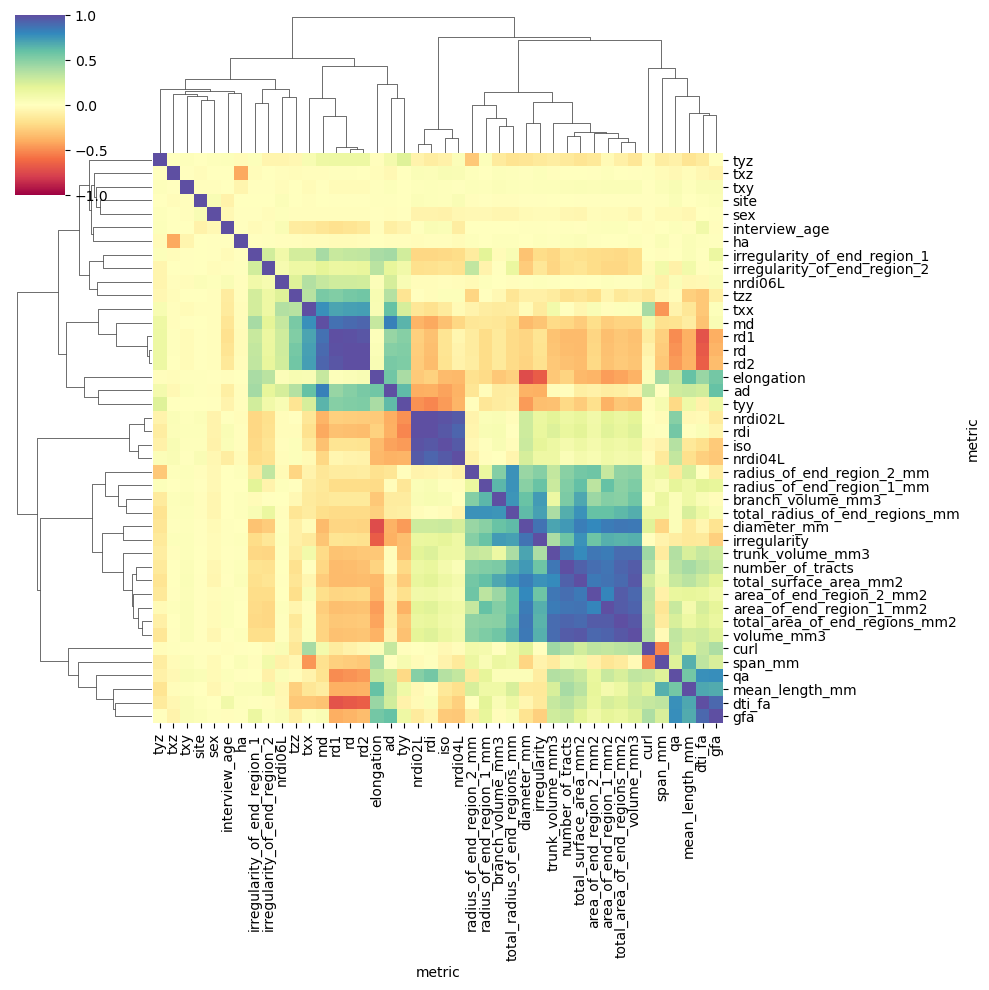

In [50]:
sns.clustermap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            vmin=-1, vmax=1,
            cmap = "Spectral")
plt.show()

Many of these relationships make sense based on the mathematical derivatives of these metrics.
* Mean length negatively corr with rd (radial diffusivity)
* Elongation (length/diameter) negatively correlated with irregularity (SA/len*diam) 
* Curl (length/span) negatively correlated with span 
* Trunk volume positively correlated with number of tracts

In [18]:
# Narrow down the metrics based on which are quite correlated to ease in viz
metrics_reduced = ['ad', 'area_of_end_region_1_mm2', 'area_of_end_region_2_mm2',
       'branch_volume_mm3', 'curl', 'diameter_mm', 'dti_fa', 'elongation',
       'gfa', 'ha', 'irregularity', 'irregularity_of_end_region_1',
       'irregularity_of_end_region_2', 'md', 'mean_length_mm',
       'nrdi06L', 'number_of_tracts', 'qa',
       'radius_of_end_region_1_mm', 'radius_of_end_region_2_mm', 'rd',
       'rdi', 'span_mm',
       'total_radius_of_end_regions_mm', 'total_surface_area_mm2',
       'trunk_volume_mm3', 'txx', 'txy', 'txz', 'tyy', 'tyz', 'tzz',
       'volume_mm3']

In [19]:
len(metrics_reduced)

33

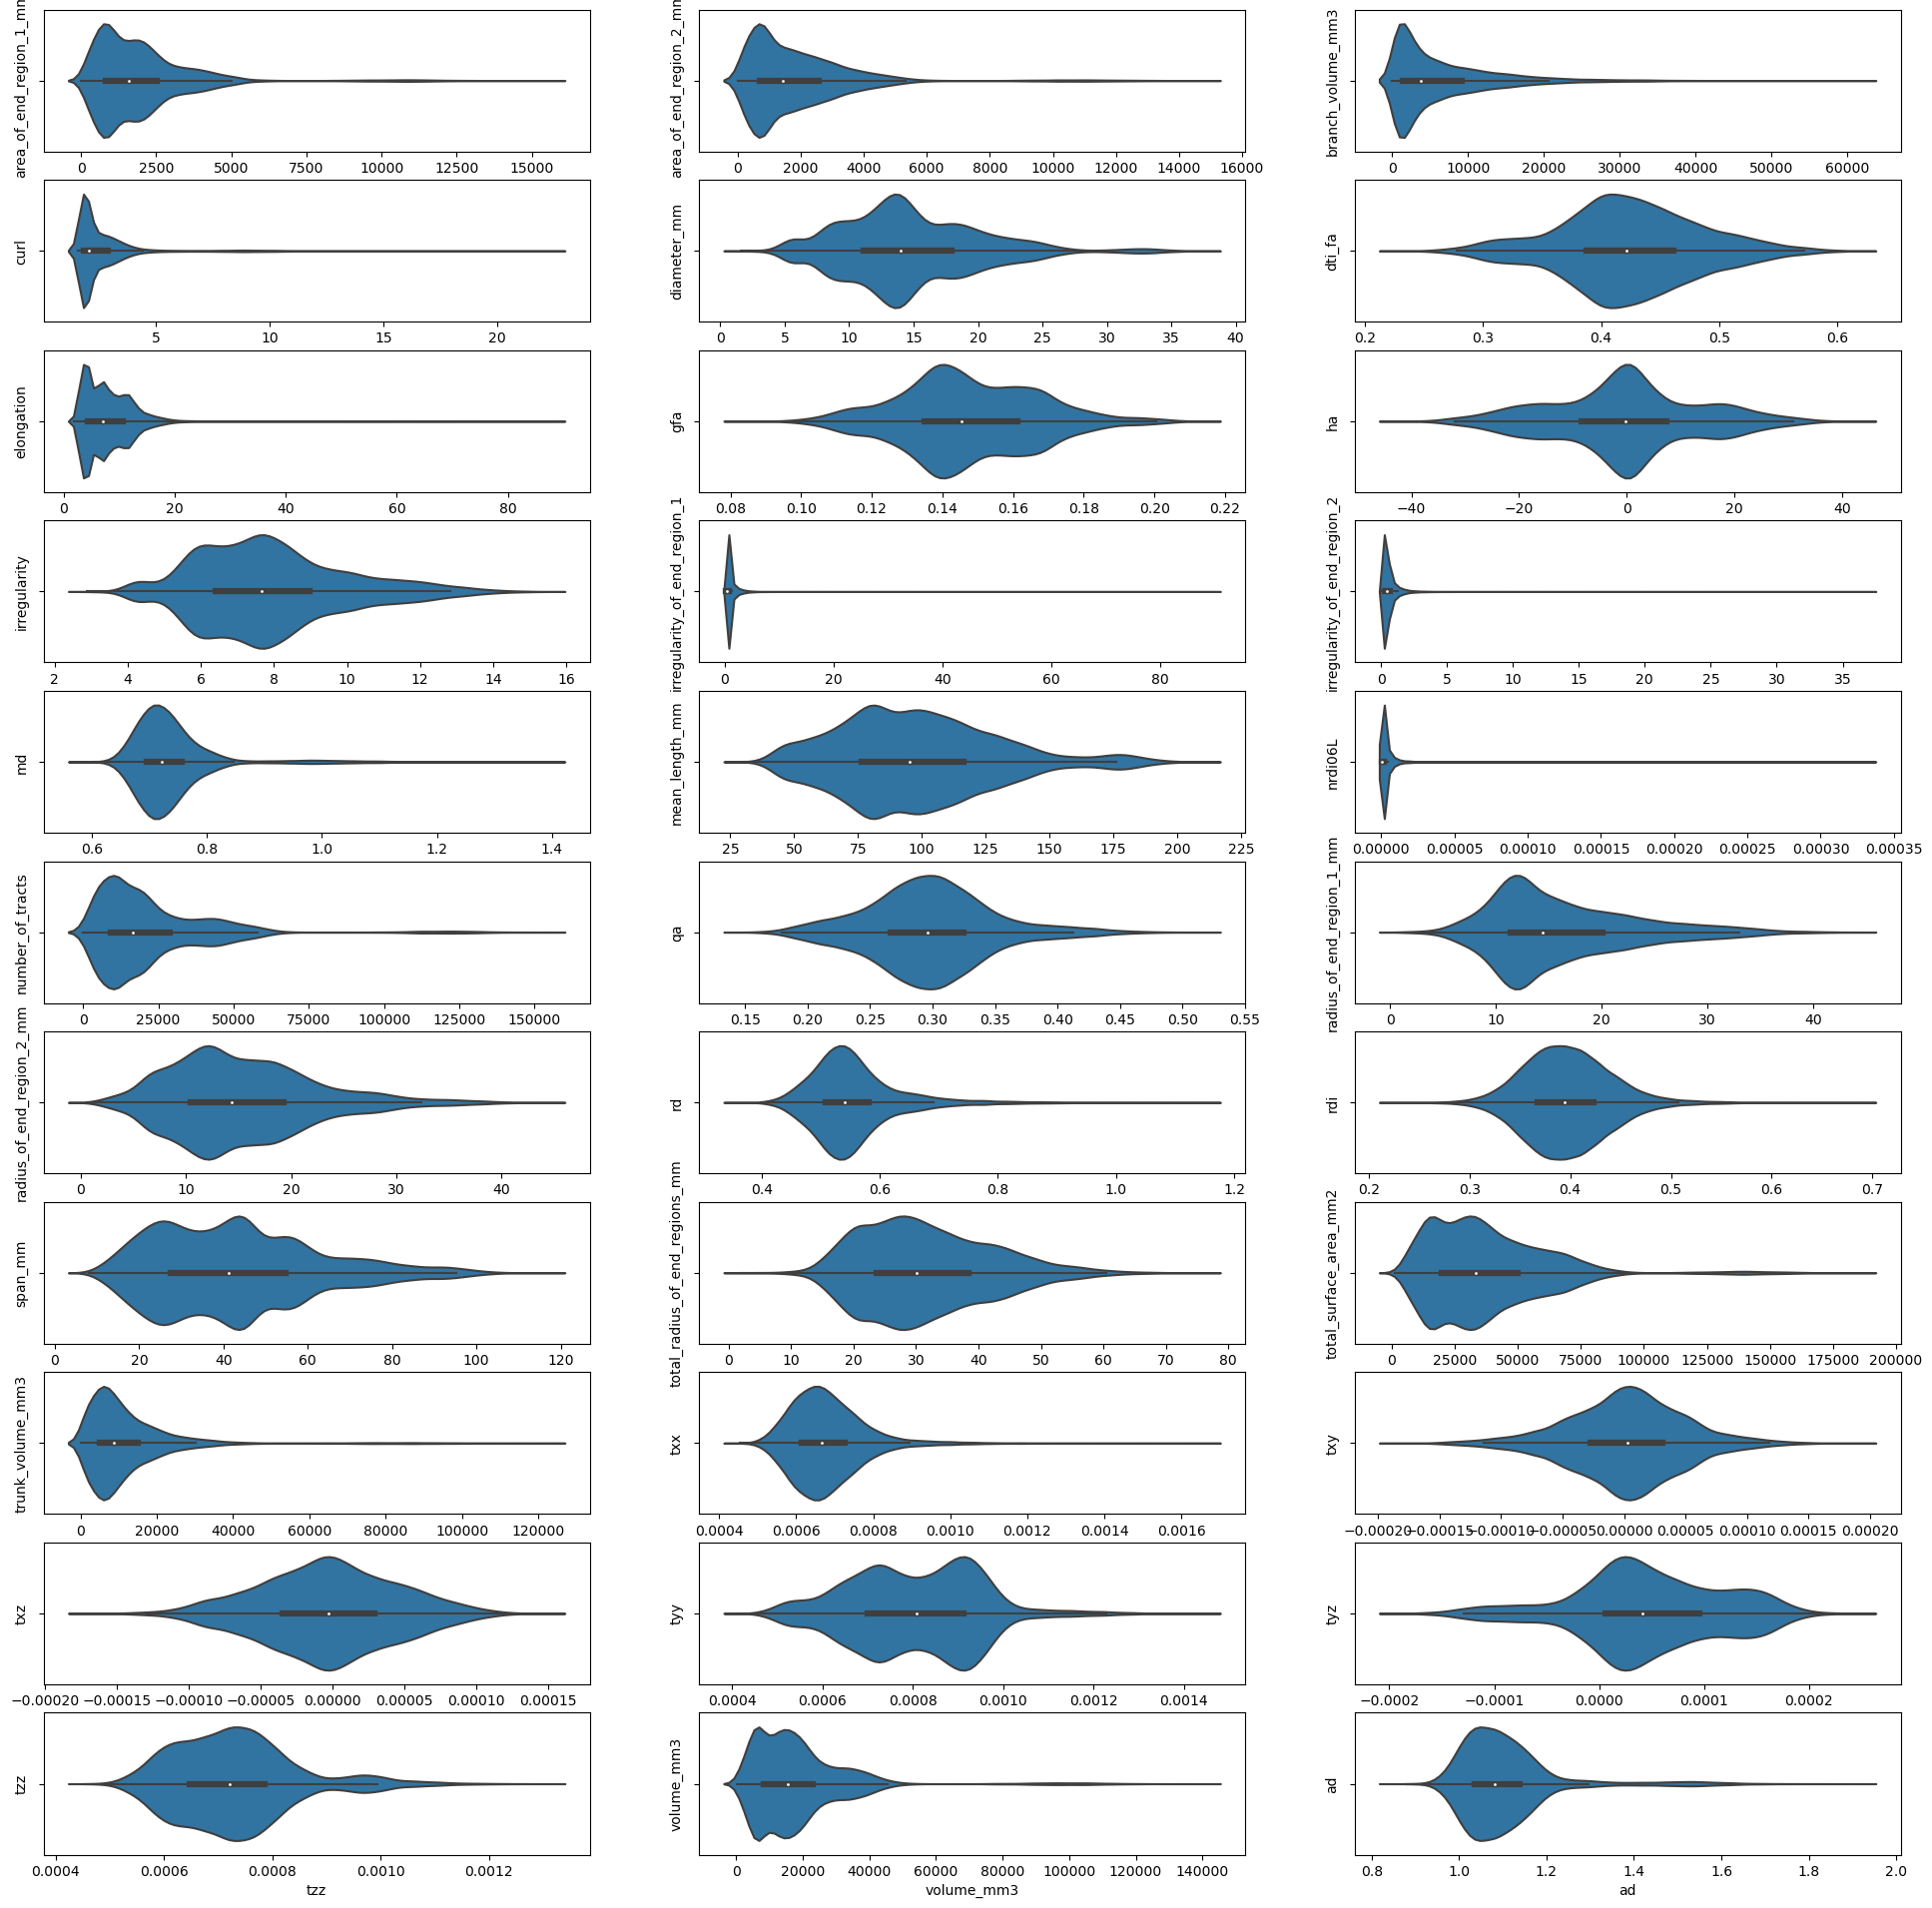

In [65]:
num_dems = 3
metrics_long["all"] = ""
num_metrics = metrics_long[metrics_reduced].columns.nunique()  
fig, axes = plt.subplots(int(num_metrics/3), 3, figsize=(24, 24))
axes = axes.flatten()

for idx, col in enumerate(metrics_long[metrics_reduced]):
    sns.violinplot(ax = axes[idx - 1], data = metrics_long, x=col, y="all")
    axes[idx - 1].set(ylabel = col)
    
plt.show()

In [62]:
metrics_long[metrics_reduced].describe()

metric,ad,area_of_end_region_1_mm2,area_of_end_region_2_mm2,branch_volume_mm3,curl,diameter_mm,dti_fa,elongation,gfa,ha,...,total_radius_of_end_regions_mm,total_surface_area_mm2,trunk_volume_mm3,txx,txy,txz,tyy,tyz,tzz,volume_mm3
count,32029.000000,32029.000000,32029.000000,32029.000000,32029.000000,32029.000000,32029.000000,32029.000000,32029.000000,32029.000000,...,32029.000000,32029.000000,32029.000000,32029.000000,32029.000000,32029.000000,32029.000000,32029.000000,32029.000000,32029.000000
mean,1.104141,1950.948882,1864.834341,6307.239284,2.655820,14.730091,0.423807,7.791164,0.147366,-0.346374,...,31.544904,37559.192183,12038.194695,0.000680,0.000002,-0.000003,0.000804,0.000046,0.000729,18345.433633
std,0.113588,1686.954919,1752.578412,6798.152969,1.595585,5.382267,0.059797,4.205952,0.019468,13.725780,...,10.428821,23808.669249,12565.759140,0.000101,0.000048,0.000047,0.000144,0.000071,0.000114,15114.758240
min,0.845712,3.937500,2.250000,0.000000,1.551280,1.628100,0.226978,1.882700,0.083040,-42.516900,...,1.839820,1034.440000,0.000000,0.000438,-0.000187,-0.000172,0.000418,-0.000192,0.000452,145.969000
25%,1.034480,834.750000,704.812000,1447.450000,1.838260,11.152000,0.387765,4.281950,0.134845,-8.367270,...,23.629200,19859.100000,5005.550000,0.000615,-0.000027,-0.000034,0.000700,0.000006,0.000647,8242.590000
50%,1.082140,1589.620000,1415.810000,3746.250000,2.065140,13.980400,0.421753,7.010660,0.145419,-0.209622,...,30.075200,33157.700000,8756.860000,0.000666,0.000003,-0.000003,0.000808,0.000041,0.000720,15390.800000
75%,1.138800,2505.380000,2556.560000,9109.120000,2.872720,17.960100,0.461502,10.554500,0.161201,7.303800,...,38.352300,49838.600000,15115.800000,0.000727,0.000031,0.000029,0.000912,0.000095,0.000786,23162.600000
max,1.925070,15675.800000,14872.500000,62062.000000,22.559800,37.459700,0.617752,89.226500,0.213777,42.786800,...,76.119600,185985.000000,123773.000000,0.001676,0.000193,0.000150,0.001444,0.000246,0.001311,141601.000000


In [ ]:
# sns.pairplot(metrics_long[metrics_reduced])
# plt.show()

In [ ]:
## Site analysis: ANOVA